In [1]:
import ccxt
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm
import talib as ta
import seaborn as sns


In [2]:
exchange = ccxt.ftx()
# dir(exchange)

In [3]:
market = exchange.load_markets()
market_name =list(market.keys())

In [4]:
market_trade =  [] ## Create [] to import Spot Symbols
# for i in (range(len(market_name))):
#                if ('USD' in market_name[i]) & ('USDT' not in market_name[i]) :
#                    market_trade.append(market_name[i])

In [8]:
market_trade= [market_name[i] for i in range(len(market_name)) \
               if ('USD' in market_name[i]) & ('USDT' not in market_name[i]) & ('HALF' not in market_name[i] ) \
             & ('BULL' not in market_name[i] ) & ('BEAR' not in market_name[i] ) & ('HEDGE' not in market_name[i] )]
market_trade[0:10]

['1INCH/USD',
 'AAPL/USD',
 'AAVE/USD',
 'ABNB/USD',
 'ACB/USD',
 'AGLD/USD',
 'AKRO/USD',
 'ALCX/USD',
 'ALEPH/USD',
 'ALICE/USD']

In [9]:
def get_data(symbols,timeframe='1d'):
      data= pd.DataFrame(exchange.fetch_ohlcv(symbols,timeframe),columns=['date','open','high','low','close','volume'])
      # df.drop(columns='volume',inplace=True)
      data['volume'] =(data['volume'].astype('int'))
      data['date']=data['date'].apply(exchange.iso8601)
      data['date']=pd.to_datetime(data['date'])
    #   df['date']=df['date'].apply(lambda x: x.strftime('%Y-%m-%d %H:%M'))
    #   df['date']=pd.to_datetime(df['date'])
      data.set_index('date',inplace=True)
    #   df.dropna(inplace=True)
      return data

def cal_consecutive(df):

    df['win']= np.sign(df) # assign sign on log
    blocks = df['win'].ne(df['win'].shift()).cumsum() 
    df['consecutive_WL'] = df['win'].groupby(blocks).cumsum()
    return df['consecutive_WL'] 

In [10]:
df  = get_data('SLP/USD')

df['log'] = np.log(df['close'] / df['close'].shift(1)).fillna(0)
df['log_30'] =np.log(df['close'] / df['close'].shift(30)).fillna(0)
df['roc_30'] =(df['close'] / df['close'].shift(30)) - 1

### 
df['win']= np.sign(df['log']) # assign sign on log
blocks = df['win'].ne(df['win'].shift()).cumsum() 
df['consecutive_WL'] = df['win'].groupby(blocks).cumsum()
df['vol_30'] =df['close'].rolling(30).std() 
df['vol_30'] =df['vol_30']/df['close']
df['rolling_ret30']= (1.+df['log']).rolling(window=5).agg(lambda x : x.prod())-1

df= df.dropna()

In [16]:
last_100= df.tail(100)
last_100

,open,high,low,close,volume,log,log_30,roc_30,win,consecutive_WL,vol_30,rolling_ret30
date,,,,,,,,,,,,
2021-11-23 00:00:00+00:00,0.063525,0.066200,0.063150,0.065100,2472052,0.024491,0.018214,0.018381,1.0,1.0,0.113558,0.058822
2021-11-24 00:00:00+00:00,0.065100,0.066000,0.062200,0.063000,1823992,-0.032790,-0.064539,-0.062500,-1.0,-1.0,0.119265,-0.054430
2021-11-25 00:00:00+00:00,0.063000,0.068900,0.062425,0.065775,2898237,0.043105,-0.065820,-0.063701,1.0,1.0,0.115220,-0.019551
2021-11-26 00:00:00+00:00,0.065775,0.066075,0.057375,0.058925,4223631,-0.109974,-0.041958,-0.041090,-1.0,-1.0,0.130719,-0.120780
2021-11-27 00:00:00+00:00,0.058925,0.060350,0.057875,0.059050,1950974,0.002119,-0.067524,-0.065295,1.0,1.0,0.133486,-0.078110
...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-26 00:00:00+00:00,0.020025,0.021700,0.019950,0.020350,1646973,0.016099,0.676094,0.966184,1.0,2.0,0.374304,0.097458
2022-02-27 00:00:00+00:00,0.020350,0.020500,0.018575,0.018950,1419276,-0.071277,0.607236,0.835351,-1.0,-1.0,0.391344,0.022027
2022-02-28 00:00:00+00:00,0.018950,0.021200,0.018700,0.020700,1445813,0.088330,0.697990,1.009709,1.0,1.0,0.347497,-0.019319


In [ ]:

import matplotlib.dates as md
symbols = 'TEST/USD'
fig  = plt.figure(figsize=(16,10))
g= sns.lineplot(data = last_100,x=last_100.index,y=last_100['close'], marker='o', linewidth = 3,alpha=0.8,color='#212121')
ax2 = g.twinx()

b= sns.barplot(data=last_100,x=last_100.index,y='log',color="#6D9886",ax=ax2,alpha=0.3) # D9CAB3 212121
patch_h = []    
for patch in b.patches:
    reading = patch.get_height()
    patch_h.append(reading)

idx_tallest = np.argmax(patch_h)   
idx_lowest = np.argmin(patch_h)   
b.patches[idx_tallest].set_facecolor('blue')  
b.patches[idx_lowest].set_facecolor('red')  
# b.set(ylabel=None)

g.xaxis.set_major_locator(md.MonthLocator(bymonthday =1 ))
g.tick_params(axis='x', rotation=45)
g.set_title(f'Charts :  {symbols} / USD ' , fontsize= 30,color='#212121',alpha=1)

g.set(xlabel=None)
g.set(ylabel=None)
# g.text(4, (last_100['c'].min()*0.005)+last_100['c'].min(),f'by {s}', fontsize=17,alpha=0.8) #add text
sns.despine(left=True, bottom=True)


# # Show ,  Plot Returns ,Frequceny consecutive sign returns 


In [40]:

bins = [-6,-4,-2,0,2, 4, 6]
df['range_count'] = pd.cut(df['consecutive_WL'], bins)
df['range_count'].value_counts()


(0, 2]      65
(-4, -2]    51
(-2, 0]     51
(-6, -4]    23
(2, 4]       4
(4, 6]       1
Name: range_count, dtype: int64

C:\Users\User\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\User\Anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


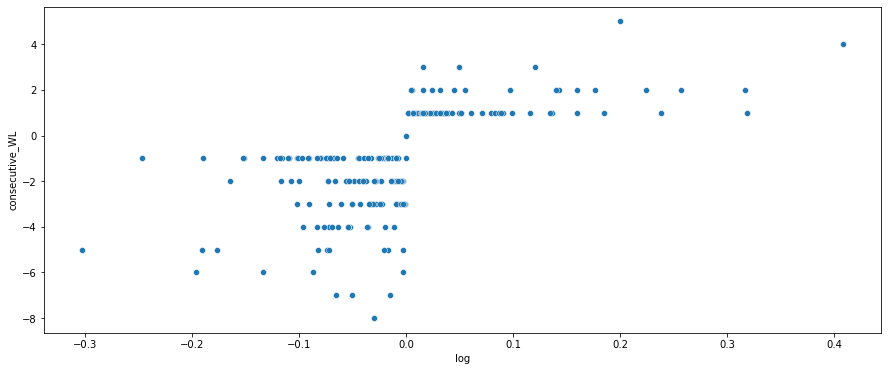

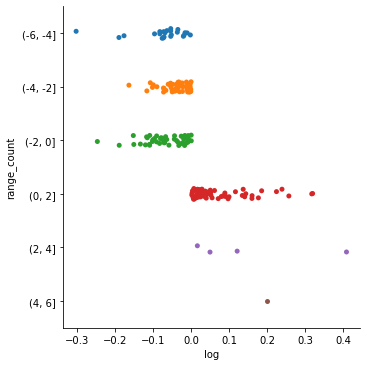

In [41]:
plt.figure(figsize=(15,6))

sns.scatterplot(df['log'],df['consecutive_WL'],data=df)
sns.catplot(df['log'],df['range_count'],data=df) # Plot ranges 
plt.show()

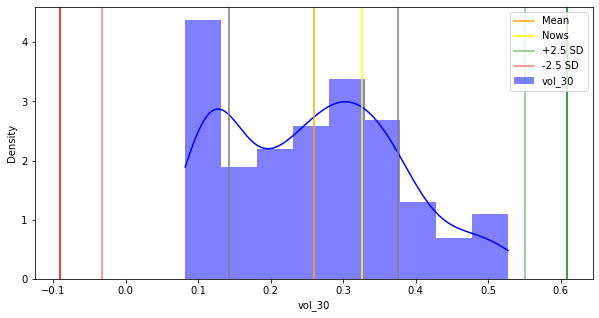

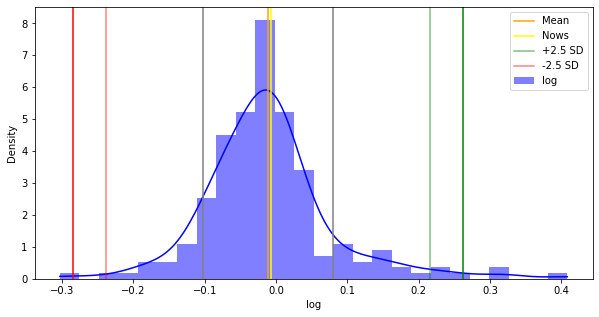

date
2022-02-26 00:00:00+00:00    0.016099
2022-02-27 00:00:00+00:00   -0.071277
2022-02-28 00:00:00+00:00    0.088330
2022-03-01 00:00:00+00:00   -0.009709
2022-03-02 00:00:00+00:00   -0.007344
Name: log, dtype: float64

In [52]:
def plot_hist(df,vt=False):
    '''Plot Histrograme and add  Verticle line -3 to 3 sd 
        df = Dataframe[Series] 
        vt = Bool [ add line on minus values ]'''
    
    plt.figure(figsize=(10,5))
    sns.histplot(df, color="blue", label=f"{df._name}", kde=True, stat="density", linewidth=0)
    plt.axvline(df.mean() , color='orange',label='Mean')  # nows

    plt.axvline(df.iloc[-1] , color='yellow',label='Nows')  # nows
    plt.axvline(df.mean()+df.std(),color='grey')
    plt.axvline(df.mean()+2.5*df.std(),color='green',label='+2.5 SD',alpha=0.5)
    plt.axvline(df.mean()+3*df.std(),color='green')
    if vt == True :
            plt.axvline(df.mean()-df.std(),color='grey')

            plt.axvline(df.mean()-2.5*df.std(),color='red',label='-2.5 SD',alpha=0.5)
            plt.axvline(df.mean()-3*df.std(),color='red',alpha=1.0)
    plt.legend()
    plt.show()
    return df.tail()



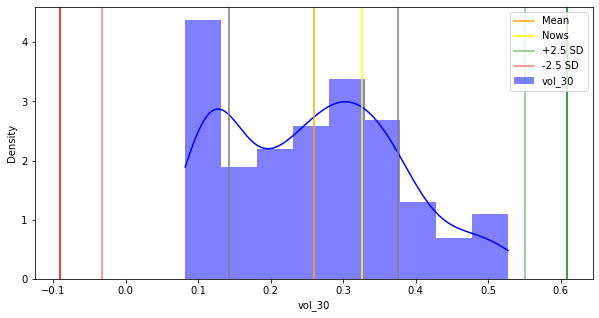

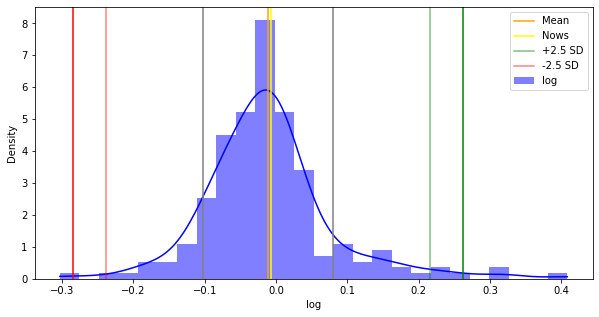

date
2022-02-26 00:00:00+00:00    0.016099
2022-02-27 00:00:00+00:00   -0.071277
2022-02-28 00:00:00+00:00    0.088330
2022-03-01 00:00:00+00:00   -0.009709
2022-03-02 00:00:00+00:00   -0.007344
Name: log, dtype: float64

In [53]:

plot_hist(df['vol_30'],True)
plot_hist(df['log'],True)

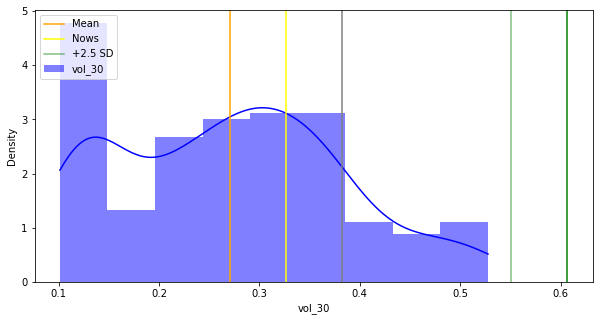

date
2022-02-26 00:00:00+00:00    0.374304
2022-02-27 00:00:00+00:00    0.391344
2022-02-28 00:00:00+00:00    0.347497
2022-03-01 00:00:00+00:00    0.338424
2022-03-02 00:00:00+00:00    0.326158
Name: vol_30, dtype: float64

In [55]:
filter_vol = df['vol_30'][df['vol_30']>=0.1]

new_df = plot_hist(filter_vol)
new_df

# Resample Data

In [58]:
df_1w  =df.resample('1W').agg({'close':'last'})

df_1w['log'] =np.log(df_1w['close'] / df_1w['close'].shift(1)).fillna(0)
df_1w['win']= np.sign(df_1w['log']) # assign sign on log
blocks = df_1w['win'].ne(df_1w['win'].shift()).cumsum() 
df_1w['consecutive_WL'] = df_1w['win'].groupby(blocks).cumsum()
df_1w['log_4'] =np.log(df_1w['close'] / df_1w['close'].shift(4)).fillna(0)
df_1w['vol_4'] =df_1w['close'].rolling(4).std() 
df_1w['vol_4'] =df_1w['vol_4']/df_1w['close'] ## normalize to percent
df_1w['rolling_ret4']= (1.+df_1w['log']).rolling(window=4).agg(lambda x : x.prod())-1
df_1w.tail()

,close,log,win,consecutive_WL,log_4,vol_4,rolling_ret4
date,,,,,,,
2022-02-06 00:00:00+00:00,0.01355,0.288913,1.0,1.0,-0.303243,0.333523,-0.422020
2022-02-13 00:00:00+00:00,0.03035,0.806410,1.0,2.0,0.380250,0.302814,-0.070216
2022-02-20 00:00:00+00:00,0.02025,-0.404642,-1.0,-1.0,0.448991,0.439559,0.051151
2022-02-27 00:00:00+00:00,0.01895,-0.066351,-1.0,-2.0,0.624330,0.370005,0.294202
2022-03-06 00:00:00+00:00,0.02035,0.071277,1.0,1.0,0.406694,0.259881,0.075673


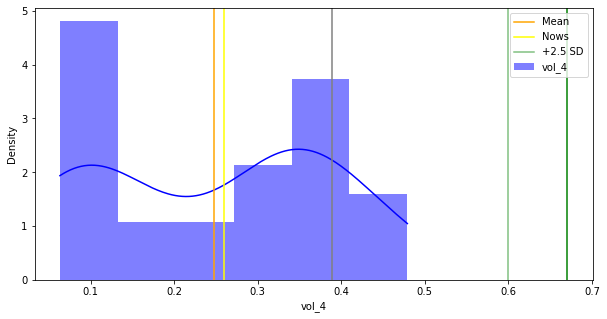

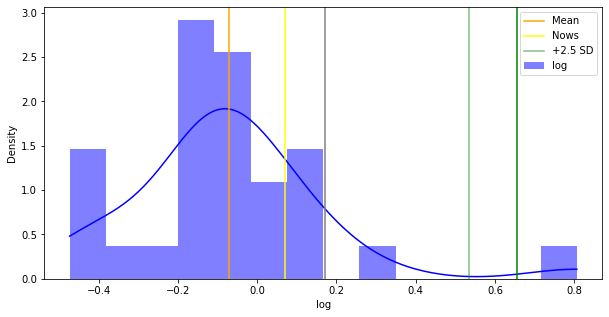

date
2022-02-06 00:00:00+00:00    0.288913
2022-02-13 00:00:00+00:00    0.806410
2022-02-20 00:00:00+00:00   -0.404642
2022-02-27 00:00:00+00:00   -0.066351
2022-03-06 00:00:00+00:00    0.071277
Freq: W-SUN, Name: log, dtype: float64

In [59]:

plot_hist(df_1w['vol_4'])
plot_hist(df_1w['log'])

# Backtest 
: Buy :  consecutive_sign < -4 : 



: Sell : consecutive_sign > 4:

In [411]:
timeframex ='1d'
# symbols = 'DOGE/USD'
scan_list = []
df_list = []
ret_plot = []

market_trade = ['ETH-PERP','BTC-PERP','BNB-PERP'] # List symbols
for symbol in market_trade :

    df  = get_data(symbol,timeframe=timeframex)
    rolling_period =30 
    df['log'] = np.log(df['close'] / df['close'].shift(1)).fillna(0)
    df[f'log_{rolling_period}'] =np.log(df['close'] / df['close'].shift(rolling_period)).fillna(0)
    # df[f'roc_{rolling_period}'] =(df['close'] / df['close'].shift(rolling_period)) - 1
    df[f'rolling_ret_{rolling_period}']= (1.+df['log']).rolling(window=rolling_period).agg(lambda x : x.prod())-1


    ### 
    df['win']= np.sign(df['log']) # assign sign on log
    blocks = df['win'].ne(df['win'].shift()).cumsum() 
    df['consecutive_WL'] = df['win'].groupby(blocks).cumsum()
    df[f'vol_{rolling_period}'] =df['close'].rolling(rolling_period).std() 
    df[f'vol_{rolling_period}'] =df['vol_30']/df['close']
    df['HHV']=df['high'].rolling(rolling_period).max()
    df['LLV']=df['low'].rolling(rolling_period).min()


    # Condition Current Price is within 25% of 52 week high
    # Condition Current Price is at least 30% above 52 week low
    df['diff_hhv'] = ((df['close'] /df['HHV']) -1)
    df['diff_llv'] = (df['close'] /df['LLV'] -1)
    df['DX']= ta.ADX(df['high'],df['low'],df['close'],timeperiod=10)


    df['sig'] = np.nan
    
    df.loc[(df['consecutive_WL']<=-3), 'sig'] = 1
    df.loc[(df['consecutive_WL']>=3) , 'sig'] = -1
    df['stg_ret'] =   df['sig'].shift(1)*df['log']
    df.name=symbol
    df.fillna(0,inplace=True)
    cum_ret = (df['stg_ret']+1).cumprod() -1
    cum_ret.name = df.name

    ## 
    if len(df[df['sig'].notna()]) >0:
        last_sig = df[df['sig'].notna()].iloc[[-1]]['sig'][0]
        last_sig_date  = df[df['sig'].notna()].iloc[[-1]].index[0]
        last_sig_entry = df[df['sig'].notna()].iloc[[-1]]['close'][0]
        now_price =df['close'].iloc[-1]
        now_sig =df['sig'].iloc[-1]
        now_date =df.index[-1]


        diff= (now_price  / last_sig_entry)-1
        combine_data  = [symbol,last_sig,last_sig_date,last_sig_entry,now_price,now_sig,now_date,diff] # add object to list >> object_list
        
        scan_list.append(combine_data) # add object_list to list >>> all_data
        df_list.append(df)
        ret_plot.append(cum_ret)

        # Debug
        print({'last_sig':last_sig,'last_entry':last_sig_entry,'last_date':last_sig_date,'symbol':symbol})
        print(now_sig,now_price,now_date,symbol)
        print('Diff ',diff*100,'%')

    else:
        print(symbol,' None Enough Data')


print('#'*50,'\n')
print('Finised')
        
    



{'last_sig': 0.0, 'last_entry': 2970.3, 'last_date': Timestamp('2022-03-02 00:00:00+0000', tz='UTC'), 'symbol': 'ETH-PERP'}
0.0 2970.3 2022-03-02 00:00:00+00:00 ETH-PERP
Diff  0.0 %
{'last_sig': 0.0, 'last_entry': 43818.0, 'last_date': Timestamp('2022-03-02 00:00:00+0000', tz='UTC'), 'symbol': 'BTC-PERP'}
0.0 43818.0 2022-03-02 00:00:00+00:00 BTC-PERP
Diff  0.0 %
{'last_sig': -1.0, 'last_entry': 409.7275, 'last_date': Timestamp('2022-03-02 00:00:00+0000', tz='UTC'), 'symbol': 'BNB-PERP'}
-1.0 409.7275 2022-03-02 00:00:00+00:00 BNB-PERP
Diff  0.0 %
################################################## 

Finised


In [295]:
# df['sig'] = df['sig'].fillna(method='ffill')
# df= df.dropna()

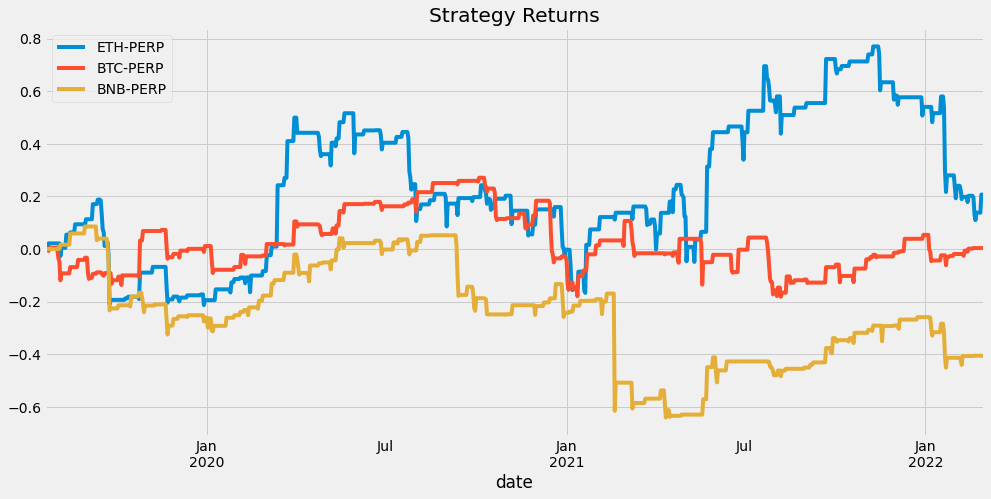

In [412]:
df_plot = pd.DataFrame(ret_plot).T
df_plot.plot(figsize=(15,7),title='Strategy Returns')

In [414]:
# Add all_data [list] to DataFrame
scan_df= pd.DataFrame(scan_list,columns=['symbols','last_sig','sig_date','sig_entry','last','sig','sig_date','diff'])
scan_df

,symbols,last_sig,sig_date,sig_entry,last,sig,sig_date,diff
0,ETH-PERP,0.0,2022-03-02 00:00:00+00:00,2970.3000,2970.3000,0.0,2022-03-02 00:00:00+00:00,0.0
1,BTC-PERP,0.0,2022-03-02 00:00:00+00:00,43818.0000,43818.0000,0.0,2022-03-02 00:00:00+00:00,0.0
2,BNB-PERP,-1.0,2022-03-02 00:00:00+00:00,409.7275,409.7275,-1.0,2022-03-02 00:00:00+00:00,0.0


In [415]:
def calc_MDD(networth):
  df = pd.Series(networth, name="nw").to_frame()

  max_peaks_idx = df.nw.expanding(min_periods=1).apply(lambda x: x.argmax()).fillna(0).astype(int)
  df['max_peaks_idx'] = pd.Series(max_peaks_idx).to_frame()

  nw_peaks = pd.Series(df.nw.iloc[max_peaks_idx.values].values, index=df.nw.index)

  df['dd'] = ((df.nw-nw_peaks)/nw_peaks)
  df['mdd'] = df.groupby('max_peaks_idx').dd.apply(lambda x: x.expanding(min_periods=1).apply(lambda y: y.min())).fillna(0)

  return df

['ETH-PERP', 'BTC-PERP', 'BNB-PERP']


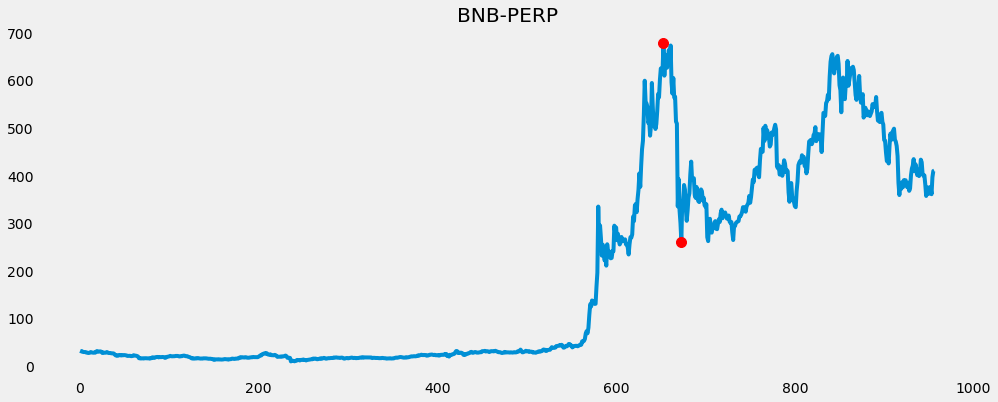

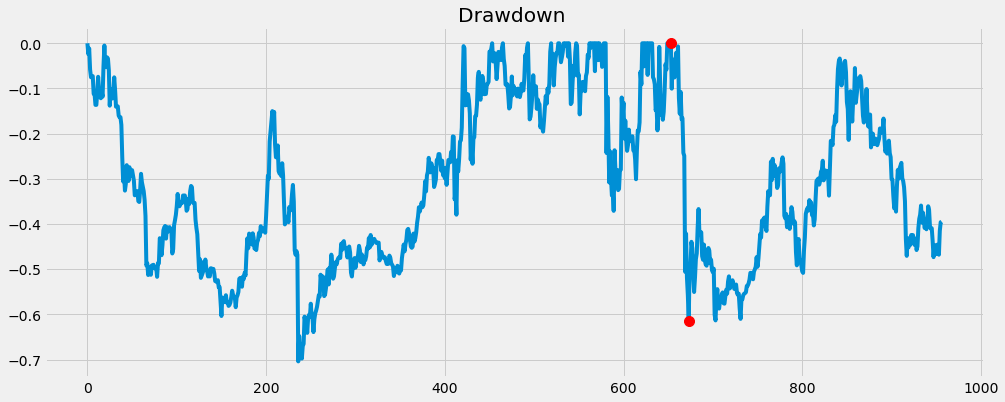

##################################################
index 673 653
-0.6154641688397072 0.0 Drawdown -inf %


C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: divide by zero encountered in double_scalars


In [416]:
# Max drawdown On chart Data 
# https://stackoverflow.com/questions/22607324/start-end-and-duration-of-maximum-drawdown-in-python

plt.style.use('fivethirtyeight')

print([df_.name for df_ in df_list])
df_selected= df_list[2]
param ='close'
end = (np.maximum.accumulate(df_selected[param]) - df_selected[param]).argmax()
start = np.argmax(df_selected[param][:end]) #.argmax()
llv = df_selected.iloc[end]['close']#.values[0]
hhv = df_selected.iloc[start]['close']#.values[0]

end_start = [end,start]
plt.figure(figsize=(15,6))
df_plot =df_selected.reset_index()
plt.plot(df_plot.index,df_plot.close)
plt.plot( [end, start], [llv, hhv], color='Red',marker='o',linestyle='None', markersize=10 )

plt.title(f"{df_selected.name}")
plt.grid(False)
plt.show()

plt.figure(figsize=(15,6))
dd =calc_MDD(df_plot['close'])
plt.plot(df_plot.index,dd['dd'])
llv = dd.iloc[end]['dd']#.values[0]
hhv = dd.iloc[start]['dd']#.values[0]
plt.plot( [end, start], [llv, hhv], color='Red',marker='o',linestyle='None', markersize=10 )

plt.title('Drawdown ')
plt.show()
print('#'*50)
print('index',end,start)
print(llv,hhv , 'Drawdown',round(llv/hhv-1,5)*100,'%')

In [417]:
# ## Test function 

# n = 1000
# xs = np.random.randn(n).cumsum()
# i = np.argmax(np.maximum.accumulate(xs) - xs) # end of the period
# j = np.argmax(xs[:i]) # start of period
# p_end  = xs[i]
# p_start = xs[j]
# plt.plot(xs)
# plt.plot([i, j], [p_end, p_start], 'o', color='Red', markersize=10)
# print(f'{p_start} : {p_end}')


* Consecutive INDICATOR


In [418]:
pd.set_option('display.width', 1000)
pd.set_option('display.max_columns', 500)

inc = df['consecutive_WL'] > df['consecutive_WL'].shift(1)
des = df['consecutive_WL'] < df['consecutive_WL'].shift(1)
df['up_down_return'] =np.nan
df.loc[ inc, 'up_down_return'] = 1
df.loc[ des, 'up_down_return'] = -1

df['up_down_vol'] =np.nan
inc = df['vol_30'] > df['vol_30'].shift(1)
des = df['vol_30'] < df['vol_30'].shift(1)
df.loc[ inc, 'up_down_vol'] = 1
df.loc[ des, 'up_down_vol'] =  -1
df['con_vol'] =cal_consecutive(df['up_down_vol'])

df['up_down_dx'] =np.nan
inc = df['DX'] >= df['DX'].shift(1) ## if dx == dx.shift(1) ??
des = df['DX'] <= df['DX'].shift(1)
df.loc[ inc, 'up_down_dx'] = 1
df.loc[ des, 'up_down_dx'] =  -1
df['con_DX'] =cal_consecutive(df['up_down_dx'])

# df =df.drop(columns=['open','volume','win','high','low','HHV','LLV','log_30','rolling_ret_30'\
#                      ,'up_down_return','vol_30','DX','up_down_dx'])
# df.dropna()
# df = df.dropna()



C:\Users\User\AppData\Roaming\Python\Python37\site-packages\pandas\core\arraylike.py:364: RuntimeWarning: invalid value encountered in sign
  result = getattr(ufunc, method)(*inputs, **kwargs)
C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


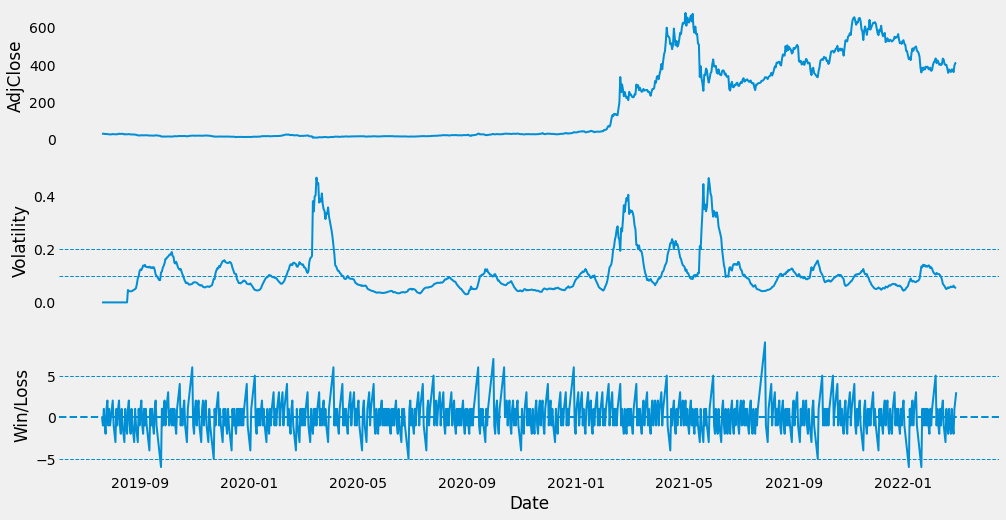

In [419]:
## Nows ## 
# df['vol_30'][-100:].plot()
plt.style.use('fivethirtyeight')

fig, (ax0,ax1,ax2) = plt.subplots(3, 1, sharex=True, figsize=(15, 8))

ax0.plot(df.index, df['close'], label='X Symbols',linewidth=2)
# ax0.set_xlabel('Date')
ax0.set_ylabel('AdjClose')
ax0.grid(False)
ax0.spines['top'].set_visible(False)
ax0.spines['right'].set_visible(False)
ax0.spines['left'].set_visible(False)
ax0.spines['bottom'].set_visible(False)



ax1.plot(df.index,df['vol_30'],label='Volatility',linewidth=2)
ax1.axhline(0.2,label='grey',linestyle ='--',linewidth=1)
ax1.axhline(0.1,label='grey',linestyle ='--',linewidth=1)
# ax1.set_xlabel('Date')
ax1.set_ylabel('Volatility')

ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.grid(False)




ax2.plot(df.index,df['consecutive_WL'],label='Win/Loss',linewidth=2)
ax2.axhline(5,label='grey',linestyle ='--',linewidth=1)
ax2.axhline(0,label='grey',linestyle ='--',linewidth=2)

ax2.axhline(-5,label='grey',linestyle ='--',linewidth=1)
ax2.set_xlabel('Date')
ax2.set_ylabel('Win/Loss')

ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.grid(False)


In [420]:
report =df.copy()
report = report[report['sig'].notna()]
report.reset_index(inplace=True)

report['p_sig'] =report.sig.shift(1)
report['p_date'] =report.reset_index().date.shift(1)###previous signal
report['p_close'] =report.close.shift(1)
report['ret']=report['close'].pct_change()
# report['hp'] =report['date']-report['p_date']


In [384]:
report =df.copy()
report['p_sig'] =report.sig.shift(1)
report.iloc[-1]['sig'] == np.nan

False

In [61]:
# TEST
# (df.loc[(df.index>='2020-10-16')&(df.index<='2020-11-08')]['close'].pct_change()+1).cumprod()-1
# (df.loc[(df.index>='2020-10-16')&(df.index<='2020-11-08')]['close'])
#

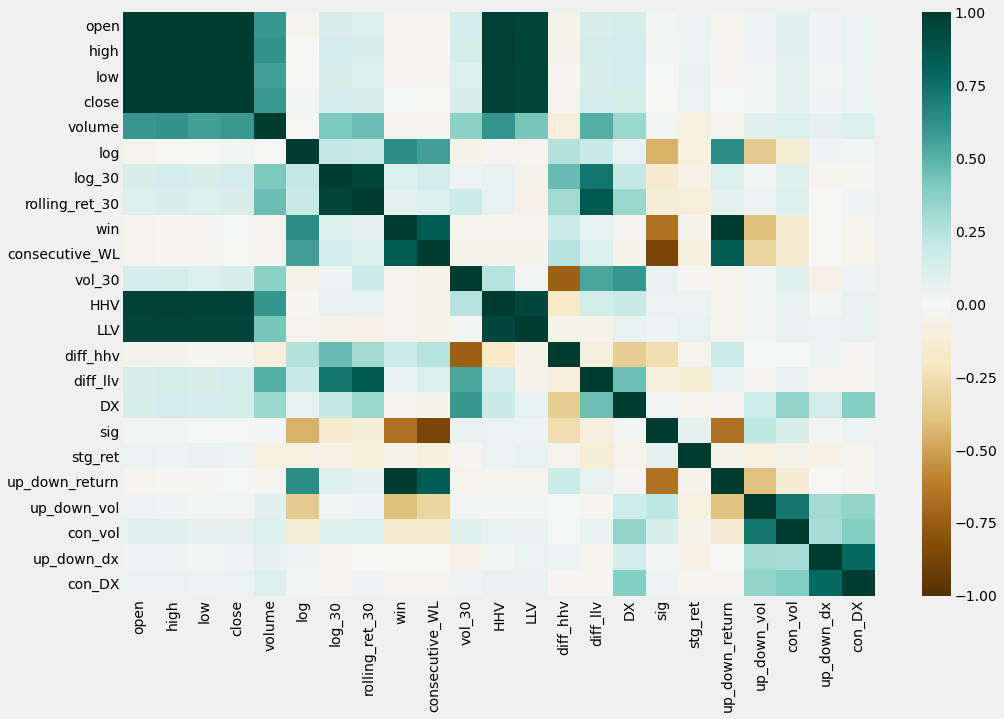

In [387]:
f, ax = plt.subplots(figsize=(15, 10))
heatmap = sns.heatmap(df.corr(), vmin=-1, vmax=1, cmap='BrBG',annot=False)


In [394]:
## Storng Volatility Consecutive Incease ##
df.loc[df.index>='2021-03-28 00:00:00+00:00','con_vol'].head(30)

date
2021-03-28 00:00:00+00:00    -3.0
2021-03-29 00:00:00+00:00    -4.0
2021-03-30 00:00:00+00:00    -5.0
2021-03-31 00:00:00+00:00     1.0
2021-04-01 00:00:00+00:00     2.0
2021-04-02 00:00:00+00:00     3.0
2021-04-03 00:00:00+00:00     4.0
2021-04-04 00:00:00+00:00    -1.0
2021-04-05 00:00:00+00:00     1.0
2021-04-06 00:00:00+00:00     2.0
2021-04-07 00:00:00+00:00     3.0
2021-04-08 00:00:00+00:00     4.0
2021-04-09 00:00:00+00:00     5.0
2021-04-10 00:00:00+00:00     6.0
2021-04-11 00:00:00+00:00     7.0
2021-04-12 00:00:00+00:00     8.0
2021-04-13 00:00:00+00:00     9.0
2021-04-14 00:00:00+00:00    10.0
2021-04-15 00:00:00+00:00    11.0
2021-04-16 00:00:00+00:00    12.0
2021-04-17 00:00:00+00:00    13.0
2021-04-18 00:00:00+00:00    14.0
2021-04-19 00:00:00+00:00    -1.0
2021-04-20 00:00:00+00:00    -2.0
2021-04-21 00:00:00+00:00     1.0
2021-04-22 00:00:00+00:00     2.0
2021-04-23 00:00:00+00:00    -1.0
2021-04-24 00:00:00+00:00     1.0
2021-04-25 00:00:00+00:00    -1.0
2021-04-2

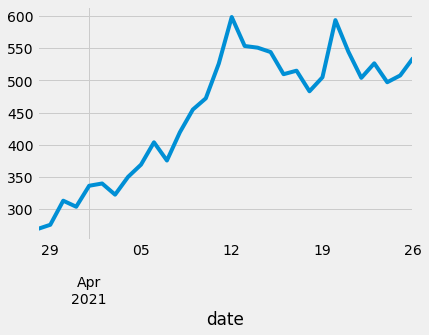

In [395]:
## Price on filter period ##
df.loc[df.index>='2021-03-28 00:00:00+00:00','close'].head(30).plot()

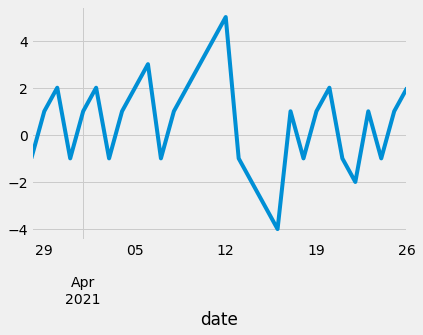

In [396]:
## Consecutive Return +/- Days ##
df.loc[df.index>='2021-03-28 00:00:00+00:00','consecutive_WL'].head(30).plot()

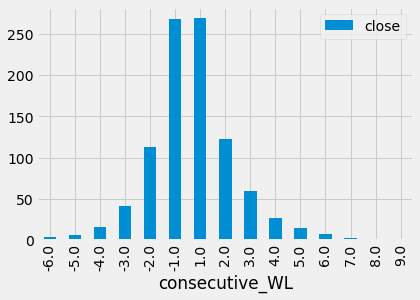

In [397]:
df[(df['consecutive_WL']<=-1) | (df['consecutive_WL'] >=1)].groupby('consecutive_WL').count()[['close']].plot(kind='bar')

In [404]:
# df.groupby('consecutive_WL').count()['close'].plot(kind='bar')

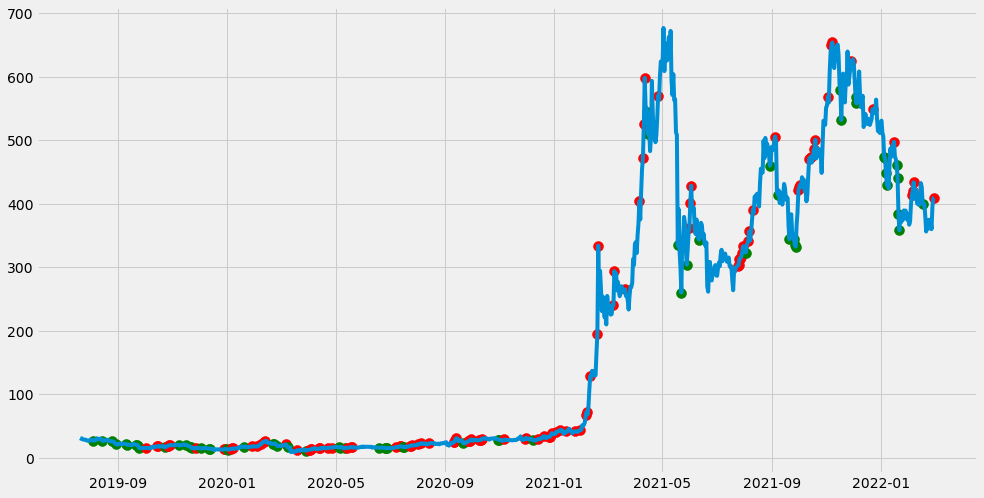

In [428]:
fig,ax =plt.subplots(figsize=(15,8))

ax.plot(df.index,df['close'])
for day, holding in df.iterrows():
    order = holding['sig']
#     print(order)
    if order == 1:
        ax.scatter(x=day, y=df.loc[day, 'close'],s=100, c='green')
    elif order == -1:
        ax.scatter(x=day, y=df.loc[day, 'close'],s=100, color='red')


In [427]:
# Review Order test
df['sig'].value_counts()

 0.0    779
-1.0    112
 1.0     66
Name: sig, dtype: int64